In [1]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# fetch data
data_path = 'AAPL.csv'
data = pd.read_csv(data_path)

data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100323,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095089,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088110,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090291,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092908,73449600


In [4]:
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
10404,2022-03-18,160.509995,164.479996,159.759995,163.979996,163.979996,123351200
10405,2022-03-21,163.509995,166.350006,163.009995,165.380005,165.380005,95811400
10406,2022-03-22,165.509995,169.419998,164.910004,168.820007,168.820007,81532000
10407,2022-03-23,167.990005,172.639999,167.649994,170.210007,170.210007,98062700
10408,2022-03-24,171.059998,174.139999,170.210007,174.070007,174.070007,90018700


### EDA 

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10409 entries, 0 to 10408
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10409 non-null  object 
 1   Open       10409 non-null  float64
 2   High       10409 non-null  float64
 3   Low        10409 non-null  float64
 4   Close      10409 non-null  float64
 5   Adj Close  10409 non-null  float64
 6   Volume     10409 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 569.4+ KB


In [9]:
## lets use only the last 5 years data or maybe last 1500 data points

# len(data) - 1500 = 8909
split_data_at = 8909

stock_data = data.iloc[split_data_at:]
stock_data.shape

(1500, 7)

- Lets use the average of the low and the high and volume of trades per day to predict the stock price

In [11]:
import math

stock_data["Average"] = (stock_data["High"] + stock_data["Low"])/2
stock_data.head(2)

C:\Users\budha\AppData\Local\Temp\ipykernel_19484\1318826724.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data["Average"] = (stock_data["High"] + stock_data["Low"])/2


,Date,Open,High,Low,Close,Adj Close,Volume,Average
8909,2016-04-12,27.334999,27.625000,27.165001,27.610001,25.528584,108929200,27.395001
8910,2016-04-13,27.700001,28.084999,27.700001,28.010000,25.898418,133029200,27.892500


In [20]:
# reset index of stock data
stock_data = stock_data.reset_index(drop = True)

In [21]:
# prepare our input data
# we will be taking input features as Volume and Average

input_data = stock_data.iloc[:, [6,7]].values

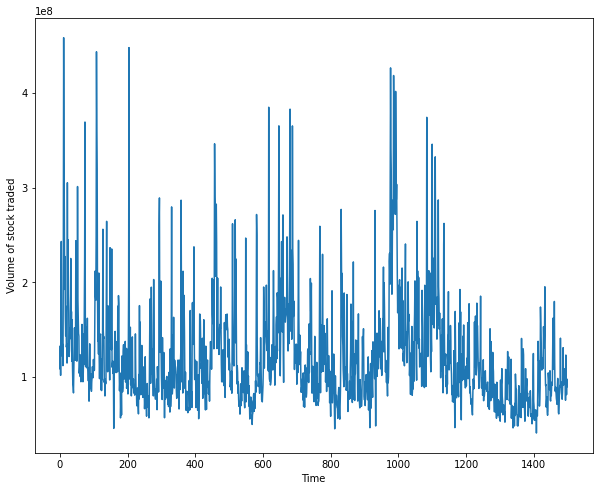

In [23]:
# plot the volume data and check
plt.figure(figsize= (10,8))
plt.plot(stock_data['Volume'])
plt.ylabel('Volume of stock traded')
plt.xlabel('Time')
plt.show();

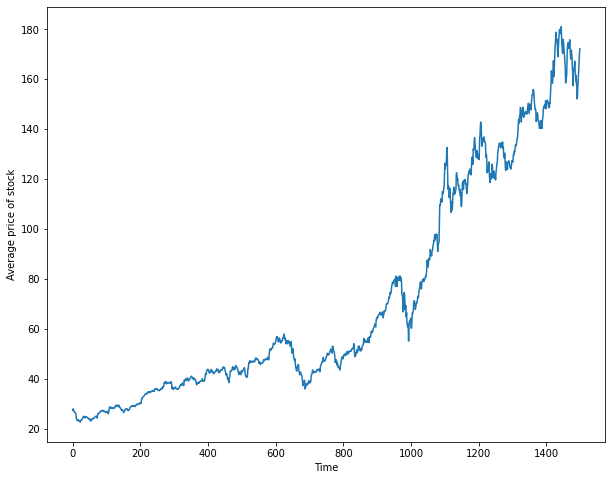

In [24]:
# plot the volume data and check
plt.figure(figsize= (10,8))
plt.plot(stock_data['Average'])
plt.ylabel('Average price of stock')
plt.xlabel('Time')
plt.show();

In [26]:
## Scaling data between 0 and 1 range
from sklearn.preprocessing import MinMaxScaler

sc= MinMaxScaler(feature_range=(0,1))
input_data[:,0:2] = sc.fit_transform(input_data[:,:])

In [28]:
# check input data
input_data[:4]

array([[0.16274038, 0.02959963],
       [0.22047759, 0.03274197],
       [0.14588973, 0.0331999 ],
       [0.35158852, 0.0318656 ]])

- We will be creating the data that will go back to 50 business days in past for the prediction.
- And uses 30% of the latest data for testing

For RNN LSTM to predict the data we need to convert the input data.

Input data is in the form: [Volume of stocks traded, Average stock price] and we need to create a time series data.

The time series data for today should contain the [Volume of stocks traded, Average stock price] for past 50 days and the target variable will be Apple’s stock price today and so on.

As the stock price prediction is based on multiple input features, it is a multivariate regression problem.

We loop through all the samples and for each day we go back 50 business days in the past and add the volume of the stocks traded an average stock price.

In [29]:
# set the look back period
lookback= 50

# set up test size
test_size=int(.3 * len(stock_data))

# intialize train and test data
X=[]
y=[]
for i in range(len(stock_data)-lookback-1):
    t=[]
    for j in range(0,lookback):
        
        t.append(input_data[[(i+j)], :])
    X.append(t)
    y.append(input_data[i+ lookback,1])

In [36]:
X[:2]

[[array([[0.16274038, 0.02959963]]),
  array([[0.22047759, 0.03274197]]),
  array([[0.14588973, 0.0331999 ]]),
  array([[0.35158852, 0.0318656 ]]),
  array([[0.48462369, 0.02701785]]),
  array([[0.21211744, 0.02570723]]),
  array([[0.19511826, 0.02564406]]),
  array([[0.2041406 , 0.02430185]]),
  array([[0.22455801, 0.02323599]]),
  array([[0.17040002, 0.02249383]]),
  array([[0.43857479, 0.02174377]]),
  array([[1.        , 0.01004287]]),
  array([[0.68990178, 0.00825852]]),
  array([[0.55850817, 0.00438981]]),
  array([[0.36329025, 0.00379766]]),
  array([[0.44638584, 0.00611888]]),
  array([[0.2949198 , 0.00635575]]),
  array([[0.24571139, 0.00401083]]),
  array([[0.32054841, 0.00286601]]),
  array([[0.21740243, 0.00370291]]),
  array([[0.22459347, 0.00316603]]),
  array([[0.17698829, 0.00344237]]),
  array([[6.33094111e-01, 4.57929688e-04]]),
  array([[0.32718843, 0.        ]]),
  array([[0.4888239 , 0.00345026]]),
  array([[0.35137673, 0.00476879]]),
  array([[0.30485635, 0.005866

In [37]:
y[:2]

[0.00834537380495709, 0.007792700043039391]

LSTM expects the input data in a specific 3D format of batch size, time steps, no. of input features.

In our case timesteps or the widow size is 50, number of input features is 2(volume of stocks traded and the average stock price).

We can transform the input data into LSTM’s expected structure using numpy.reshape(). We need to first convert input data X into an array and then use the reshape()

In [38]:
# convert into numpy arrays

X, y= np.array(X), np.array(y)
X_test = X[:test_size+lookback]

In [39]:
test_size

450

In [40]:
X_test.shape

(500, 50, 1, 2)

In [41]:
X.shape

(1449, 50, 1, 2)

In [42]:
# reshape

X = X.reshape(X.shape[0],lookback, 2)
X_test = X_test.reshape(X_test.shape[0],lookback, 2)
print(X.shape)
print(X_test.shape)

(1449, 50, 2)
(500, 50, 2)


### Create Model

In [44]:
import tensorflow as tf

In [46]:
model = tf.keras.models.Sequential([
    
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=(X.shape[1],2)),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50, 32)            4480      
                                                                 
 lstm_4 (LSTM)               (None, 50, 32)            8320      
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21,153
Trainable params: 21,153
Non-trainable params: 0
_________________________________________________________________


In [47]:
# compile model

model.compile(optimizer='adam',
             loss=tf.keras.losses.Huber(),
             metrics = ['mae'])

# fit model
num_epochs = 100
model.fit(X, y, epochs=num_epochs, batch_size=32)

Epoch 1/100
46/46 [==============================] - 26s 88ms/step - loss: 0.0143 - mae: 0.0974
Epoch 2/100
46/46 [==============================] - 4s 78ms/step - loss: 4.7976e-04 - mae: 0.0229
Epoch 3/100
46/46 [==============================] - 3s 63ms/step - loss: 4.2498e-04 - mae: 0.0206
Epoch 4/100
46/46 [==============================] - 3s 66ms/step - loss: 4.0509e-04 - mae: 0.0197
Epoch 5/100
46/46 [==============================] - 3s 63ms/step - loss: 3.8790e-04 - mae: 0.0194
Epoch 6/100
46/46 [==============================] - 3s 72ms/step - loss: 4.0403e-04 - mae: 0.0198
Epoch 7/100
46/46 [==============================] - 3s 72ms/step - loss: 3.7928e-04 - mae: 0.0190
Epoch 8/100
46/46 [==============================] - 4s 77ms/step - loss: 3.8197e-04 - mae: 0.0191
Epoch 9/100
46/46 [==============================] - 4s 81ms/step - loss: 3.4332e-04 - mae: 0.0179
Epoch 10/100
46/46 [==============================] - 3s 74ms/step - loss: 3.3180e-04 - mae: 0.0175
Epoch 11/100

46/46 [==============================] - 3s 66ms/step - loss: 8.8562e-05 - mae: 0.0093
Epoch 84/100
46/46 [==============================] - 3s 70ms/step - loss: 7.8393e-05 - mae: 0.0086
Epoch 85/100
46/46 [==============================] - 3s 68ms/step - loss: 8.7738e-05 - mae: 0.0087
Epoch 86/100
46/46 [==============================] - 3s 70ms/step - loss: 7.6378e-05 - mae: 0.0083
Epoch 87/100
46/46 [==============================] - 3s 68ms/step - loss: 7.2717e-05 - mae: 0.0082
Epoch 88/100
46/46 [==============================] - 3s 61ms/step - loss: 9.5048e-05 - mae: 0.0094
Epoch 89/100
46/46 [==============================] - 3s 73ms/step - loss: 1.1749e-04 - mae: 0.0104
Epoch 90/100
46/46 [==============================] - 4s 80ms/step - loss: 7.0469e-05 - mae: 0.0081
Epoch 91/100
46/46 [==============================] - 4s 87ms/step - loss: 7.9244e-05 - mae: 0.0086
Epoch 92/100
46/46 [==============================] - 3s 70ms/step - loss: 7.5093e-05 - mae: 0.0084
Epoch 93/100


## Get predictions

In [48]:
predicted_value= model.predict(X_test)

16/16 [==============================] - 2s 22ms/step


### Plotting the predicted values against the true values and check

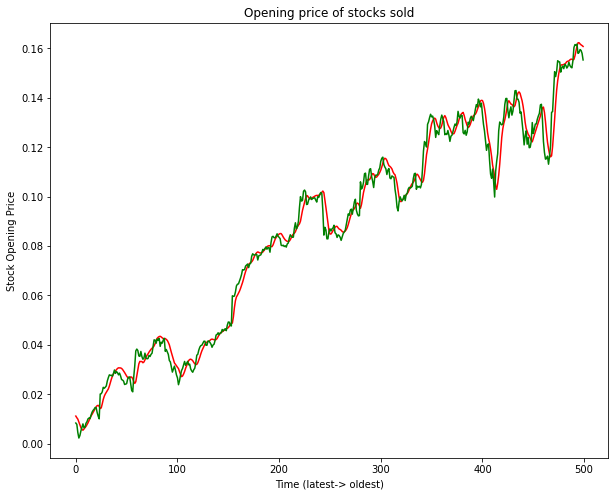

In [50]:
plt.figure(figsize=(10,8))
plt.plot(predicted_value, color= 'red')
plt.plot(input_data[lookback:test_size+(2*lookback),1], color='green')
plt.title("Opening price of stocks sold")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Stock Opening Price")
plt.show()

In [52]:
true_values = input_data[lookback:test_size+(2*lookback),1]
print(true_values.shape)

(500,)


In [54]:
results = predicted_value.squeeze()
results.shape

(500,)

### Evaluation metrics

In [56]:
print('Mean Squared error :{}'.format(tf.metrics.mean_squared_error(true_values, results)))
print('Mean Absolute error :{}'.format(tf.metrics.mean_absolute_error(true_values, results)))

Mean Squared error :2.1943104002275504e-05
Mean Absolute error :0.0033887235913425684


## USING tf.data.Dataset

In [196]:
stock_data[['Volume','Average']].head()

,Volume,Average
0,108929200,27.395001
1,133029200,27.892500
2,101895600,27.965000
3,187756000,27.753751
4,243286000,26.986250


In [70]:
d = stock_data[['Volume','Average']].values
d[:3]

array([[1.08929200e+08, 2.73950005e+01],
       [1.33029200e+08, 2.78925000e+01],
       [1.01895600e+08, 2.79650000e+01]])

## scale the input values

In [197]:
# scale the input values

sc= MinMaxScaler(feature_range=(0,1))
input_data = sc.fit_transform(d[:,:])

In [229]:
len(input_data)

1500

In [198]:
split_time = 1000

train_series = input_data[:split_time]
valid_series = input_data[split_time:]

In [199]:
# set train and test time series
train_time = range(1, split_time + 1)
print(len(train_time))

valid_time = np.array(range(split_time, (split_time + (len(d) - split_time))))
print(len(valid_time))

1000
500


In [200]:
sample_data = train_series[:10]
sample_data

array([[0.16274038, 0.02959963],
       [0.22047759, 0.03274197],
       [0.14588973, 0.0331999 ],
       [0.35158852, 0.0318656 ],
       [0.48462369, 0.02701785],
       [0.21211744, 0.02570723],
       [0.19511826, 0.02564406],
       [0.2041406 , 0.02430185],
       [0.22455801, 0.02323599],
       [0.17040002, 0.02249383]])

In [97]:
test = tf.data.Dataset.range(10)
for i in test:
    print(i.numpy())

0
1
2
3
4
5
6
7
8
9


In [106]:
datasets = test.window(size=4, shift = 1, drop_remainder=True)
datasets.flat_map(lambda window: window.batch(3))
for data in datasets:
    for i in data:
        print(i.numpy(), end = ' ')
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 6 
4 5 6 7 
5 6 7 8 
6 7 8 9 


In [116]:
datasets = tf.data.Dataset.from_tensor_slices(sample_data)
datasets = datasets.window(size=3, shift = 1, drop_remainder=True)
datasets.flat_map(lambda window: window.batch(3))
for data in datasets:
    for i in data:
        print(i.numpy(), end = ' ')
    print()

[1.08929200e+08 2.73950005e+01] [1.330292e+08 2.789250e+01] [1.018956e+08 2.796500e+01] 
[1.330292e+08 2.789250e+01] [1.018956e+08 2.796500e+01] [1.8775600e+08 2.7753751e+01] 
[1.018956e+08 2.796500e+01] [1.8775600e+08 2.7753751e+01] [2.432860e+08 2.698625e+01] 
[1.8775600e+08 2.7753751e+01] [2.432860e+08 2.698625e+01] [1.29539600e+08 2.67787505e+01] 
[2.432860e+08 2.698625e+01] [1.29539600e+08 2.67787505e+01] [1.2244400e+08 2.6768749e+01] 
[1.29539600e+08 2.67787505e+01] [1.2244400e+08 2.6768749e+01] [1.26210000e+08 2.65562495e+01] 
[1.2244400e+08 2.6768749e+01] [1.26210000e+08 2.65562495e+01] [1.3473240e+08 2.6387501e+01] 
[1.26210000e+08 2.65562495e+01] [1.3473240e+08 2.6387501e+01] [1.12126400e+08 2.62700005e+01] 


In [115]:
datasets = tf.data.Dataset.from_tensor_slices(sample_data)
datasets = datasets.window(size=3, shift = 1, drop_remainder=True)
datasets = datasets.flat_map(lambda window: window.batch(3))
datasets = datasets.map(lambda w : (w[:-1], w[-1][1]))

for data in datasets:
    for i in data:
        print(i.numpy(), end = ' ')
    print()
type(datasets)

[[1.08929200e+08 2.73950005e+01]
 [1.33029200e+08 2.78925000e+01]] 27.965 
[[1.330292e+08 2.789250e+01]
 [1.018956e+08 2.796500e+01]] 27.753751 
[[1.0189560e+08 2.7965000e+01]
 [1.8775600e+08 2.7753751e+01]] 26.98625 
[[1.8775600e+08 2.7753751e+01]
 [2.4328600e+08 2.6986250e+01]] 26.7787505 
[[2.43286000e+08 2.69862500e+01]
 [1.29539600e+08 2.67787505e+01]] 26.768749 
[[1.29539600e+08 2.67787505e+01]
 [1.22444000e+08 2.67687490e+01]] 26.5562495 
[[1.22444000e+08 2.67687490e+01]
 [1.26210000e+08 2.65562495e+01]] 26.387501 
[[1.26210000e+08 2.65562495e+01]
 [1.34732400e+08 2.63875010e+01]] 26.270000500000002 


tensorflow.python.data.ops.dataset_ops.MapDataset

### function to generate train and test data

In [201]:
def generate_windowed_datasets(series, batch_size, buffer_size, window_size):
    
    datasets = tf.data.Dataset.from_tensor_slices(series)
    datasets = datasets.window(size=window_size + 1, shift = 1, drop_remainder=True)
    datasets = datasets.flat_map(lambda window: window.batch(window_size + 1))
    datasets = datasets.map(lambda w : (w[:-1], w[-1][1]))
    datasets = datasets.shuffle(buffer_size=buffer_size)
    datasets = datasets.batch(batch_size=batch_size).prefetch(1)
    return datasets    

In [202]:
# define hyper parameters

window_size = 50
buffer_size = 1000
batch_size = 32

In [203]:
# create train and valid datasets

train_dataset = generate_windowed_datasets(train_series, batch_size, buffer_size, window_size)

In [204]:
# check data in train_dataset

for data in train_dataset.take(1):
    print('Type: {}'.format(type(data)))
    print('length :{}'.format(len(data)))
    print('Feature Shape : {}'.format(data[0].shape))
    print('Label : {}'.format(data[1].shape))

Type: <class 'tuple'>
length :2
Feature Shape : (32, 50, 2)
Label : (32,)


## Create Model

In [205]:
model_2 = tf.keras.models.Sequential([
    
    #tf.keras.layers.Lambda(lambda x:tf.expand_dims(x, axis = 0),  input_shape = [None, 2]),
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape = (50, 2)),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)
])

model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 32)            4480      
                                                                 
 lstm_1 (LSTM)               (None, 50, 32)            8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 21,153
Trainable params: 21,153
Non-trainable params: 0
_________________________________________________________________


In [206]:
## store the initial weights

init_weights = model_2.get_weights()

In [208]:
# clear session
model_2.set_weights(init_weights)

In [209]:
#tf.keras.backend.clear_session()

## set up the learning rate parameter
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch : 1e-3 * 10 ** (epoch/20))

# compile the model
model_2.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.9),
             loss=tf.keras.losses.Huber(),
             metrics = ['mae'])

# fit the model
model_2.fit(train_dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
30/30 [==============================] - 6s 46ms/step - loss: 0.0067 - mae: 0.0920 - lr: 0.0010
Epoch 2/100
30/30 [==============================] - 2s 49ms/step - loss: 0.0027 - mae: 0.0565 - lr: 0.0011
Epoch 3/100
30/30 [==============================] - 2s 48ms/step - loss: 0.0026 - mae: 0.0560 - lr: 0.0013
Epoch 4/100
30/30 [==============================] - 2s 49ms/step - loss: 0.0026 - mae: 0.0552 - lr: 0.0014
Epoch 5/100
30/30 [==============================] - 2s 49ms/step - loss: 0.0026 - mae: 0.0550 - lr: 0.0016
Epoch 6/100
30/30 [==============================] - 2s 49ms/step - loss: 0.0025 - mae: 0.0548 - lr: 0.0018
Epoch 7/100
30/30 [==============================] - 1s 44ms/step - loss: 0.0025 - mae: 0.0543 - lr: 0.0020
Epoch 8/100
30/30 [==============================] - 1s 46ms/step - loss: 0.0025 - mae: 0.0538 - lr: 0.0022
Epoch 9/100
30/30 [==============================] - 2s 49ms/step - loss: 0.0024 - mae: 0.0534 - lr: 0.0025
Epoch 10/100
30/30 [========

In [210]:
metrics = pd.DataFrame(model_2.history.history)
metrics

,loss,mae,lr
0,0.006654,0.092044,0.001000
1,0.002731,0.056542,0.001122
2,0.002614,0.056045,0.001259
3,0.002585,0.055231,0.001413
4,0.002557,0.054975,0.001585
...,...,...,...
95,442.919739,443.419739,56.234131
96,194.212341,194.712326,63.095734
97,222.192657,222.692657,70.794579
98,572.588318,573.088318,79.432823


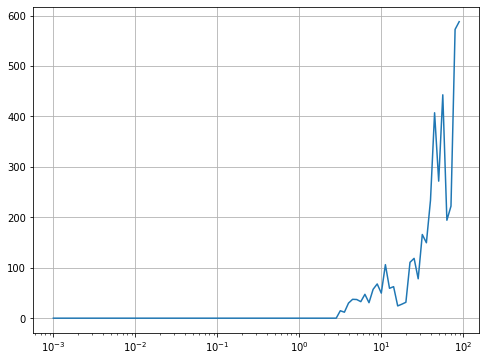

In [211]:
plt.figure(figsize=(8,6))
plt.semilogx(metrics['lr'], metrics['loss'])
plt.grid(True)
plt.show()

In [1]:
plt.figure(figsize=(8,6))
plt.semilogx(metrics['lr'], metrics['loss'])
plt.grid(True)
plt.axis([1e-2, 1, 0, 0.002])
plt.show()

NameError: name 'plt' is not defined

In [218]:
# clear session
model_2.set_weights(init_weights)
tf.keras.backend.clear_session()

## set up the learning rate parameter

#lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch : 1e-2 * 10 ** (epoch/20))
# set leraning rate
learning_rate = 3e-2

# compile the model
model_2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9),
             loss=tf.keras.losses.Huber(),
             metrics = ['mae'])

# fit the model
model_2.fit(train_dataset, epochs=100)

Epoch 1/100
30/30 [==============================] - 7s 45ms/step - loss: 0.0036 - mae: 0.0668
Epoch 2/100
30/30 [==============================] - 2s 49ms/step - loss: 0.0022 - mae: 0.0507
Epoch 3/100
30/30 [==============================] - 1s 45ms/step - loss: 0.0017 - mae: 0.0444
Epoch 4/100
30/30 [==============================] - 2s 50ms/step - loss: 0.0011 - mae: 0.0364
Epoch 5/100
30/30 [==============================] - 2s 49ms/step - loss: 6.2865e-04 - mae: 0.0273
Epoch 6/100
30/30 [==============================] - 2s 50ms/step - loss: 3.2189e-04 - mae: 0.0196
Epoch 7/100
30/30 [==============================] - 2s 50ms/step - loss: 2.1000e-04 - mae: 0.0154
Epoch 8/100
30/30 [==============================] - 1s 45ms/step - loss: 1.6073e-04 - mae: 0.0131
Epoch 9/100
30/30 [==============================] - 2s 45ms/step - loss: 1.5246e-04 - mae: 0.0128
Epoch 10/100
30/30 [==============================] - 2s 47ms/step - loss: 1.4765e-04 - mae: 0.0128
Epoch 11/100
30/30 [=====

In [219]:
history = pd.DataFrame(model_2.history.history)
history

,loss,mae
0,0.003568,0.066828
1,0.002177,0.050689
2,0.001655,0.044419
3,0.001123,0.036439
4,0.000629,0.027272
...,...,...
95,0.000111,0.011534
96,0.000111,0.011376
97,0.000112,0.011621
98,0.000113,0.011619


In [220]:
# plot loss and accuracy values 
def plot_metrics(df, num_epochs):
	
	epoch_range = range(num_epochs)
	plt.figure(figsize=(8,6))
	plt.plot(epoch_range, df['loss'], label = 'training_loss')
	plt.plot(epoch_range, df['mae'], label = 'mae')
# 	plt.plot(epoch_range, df['accuracy'], label = 'training_accuracy')
# 	plt.plot(epoch_range, df['val_accuracy'], label = 'validation_accuracy')
	plt.legend(loc='best')
	plt.show()

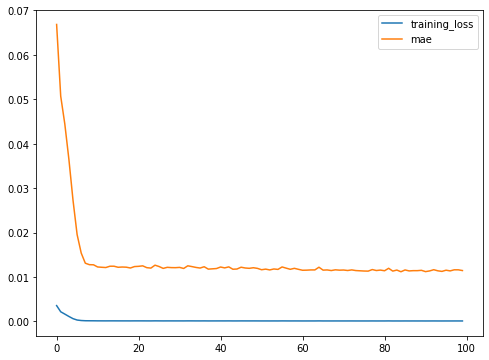

In [221]:
plot_metrics(history, 100)

### prepare validation data and predict

In [223]:
# function to generate validation data and predict on it 
def prediction(model, series, batch_size, window_size):
    
    datasets = tf.data.Dataset.from_tensor_slices(series)
    datasets = datasets.window(size=window_size, shift = 1, drop_remainder=True)
    datasets = datasets.flat_map(lambda window: window.batch(window_size))
    datasets = datasets.batch(batch_size=batch_size).prefetch(1)
    
    prediction = model.predict(datasets)
    return prediction

In [236]:
## generate forecast data

forecast_data = input_data[split_time-window_size:-1]
predictions = prediction(model_2, forecast_data, batch_size, window_size)

results = predictions.squeeze()
print(results.shape)

16/16 [==============================] - 0s 21ms/step
(500,)


In [243]:
# get true results
# these are the average price values that are in the 2nd column of every data item

true_values = valid_series[:, 1]
true_values.shape

(500,)

## Evaluation metrics

In [244]:
print('Mean Squared error :{}'.format(tf.metrics.mean_squared_error(true_values, results)))
print('Mean Absolute error :{}'.format(tf.metrics.mean_absolute_error(true_values, results)))

Mean Squared error :0.006710787769407034
Mean Absolute error :0.06727644801139832


In [245]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

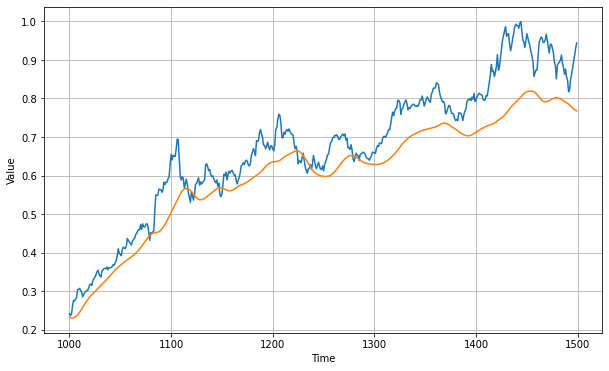

In [246]:
plot_series(valid_time, (true_values, results))

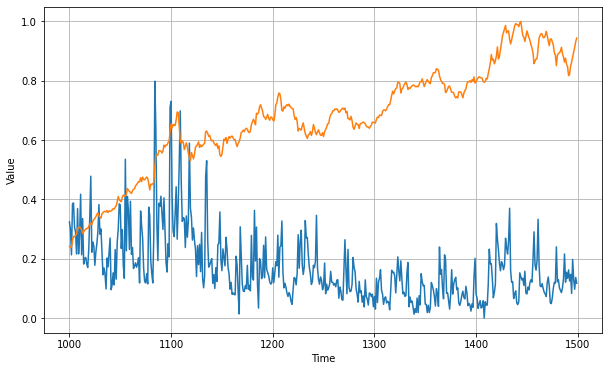

In [248]:
plot_series(valid_time, valid_series)

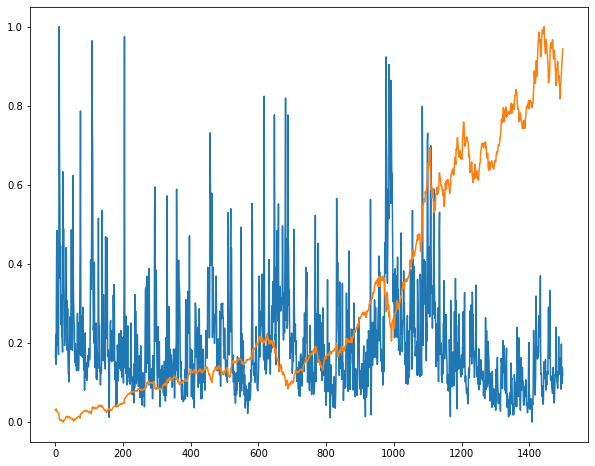

In [250]:
plt.figure(figsize=(10, 8))
plt.plot(input_data)

## using adam optimizer

In [251]:
model_adam = tf.keras.models.Sequential([
    
    #tf.keras.layers.Lambda(lambda x:tf.expand_dims(x, axis = 0),  input_shape = [None, 2]),
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape = (50, 2)),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)
])

model_adam.compile(optimizer='adam',loss=tf.keras.losses.Huber(), metrics = ['mae'])

model_adam.fit(train_dataset, epochs=100)

Epoch 1/100
30/30 [==============================] - 6s 45ms/step - loss: 0.0026 - mae: 0.0493
Epoch 2/100
30/30 [==============================] - 2s 50ms/step - loss: 1.7765e-04 - mae: 0.0143
Epoch 3/100
30/30 [==============================] - 1s 43ms/step - loss: 1.1940e-04 - mae: 0.0118
Epoch 4/100
30/30 [==============================] - 1s 45ms/step - loss: 1.1842e-04 - mae: 0.0114
Epoch 5/100
30/30 [==============================] - 2s 49ms/step - loss: 1.0827e-04 - mae: 0.0111
Epoch 6/100
30/30 [==============================] - 2s 47ms/step - loss: 9.2231e-05 - mae: 0.0102
Epoch 7/100
30/30 [==============================] - 2s 46ms/step - loss: 1.0280e-04 - mae: 0.0108
Epoch 8/100
30/30 [==============================] - 2s 47ms/step - loss: 9.3921e-05 - mae: 0.0104
Epoch 9/100
30/30 [==============================] - 2s 46ms/step - loss: 8.1822e-05 - mae: 0.0095
Epoch 10/100
30/30 [==============================] - 2s 49ms/step - loss: 7.5950e-05 - mae: 0.0092
Epoch 11/100


30/30 [==============================] - 1s 44ms/step - loss: 4.0819e-05 - mae: 0.0067
Epoch 84/100
30/30 [==============================] - 1s 45ms/step - loss: 3.9223e-05 - mae: 0.0066
Epoch 85/100
30/30 [==============================] - 2s 47ms/step - loss: 3.6140e-05 - mae: 0.0060
Epoch 86/100
30/30 [==============================] - 2s 46ms/step - loss: 3.4972e-05 - mae: 0.0060
Epoch 87/100
30/30 [==============================] - 2s 47ms/step - loss: 3.3279e-05 - mae: 0.0058
Epoch 88/100
30/30 [==============================] - 2s 46ms/step - loss: 3.7888e-05 - mae: 0.0065
Epoch 89/100
30/30 [==============================] - 2s 46ms/step - loss: 4.2215e-05 - mae: 0.0068
Epoch 90/100
30/30 [==============================] - 2s 47ms/step - loss: 3.7406e-05 - mae: 0.0063
Epoch 91/100
30/30 [==============================] - 2s 52ms/step - loss: 3.9316e-05 - mae: 0.0065
Epoch 92/100
30/30 [==============================] - 2s 52ms/step - loss: 3.2395e-05 - mae: 0.0058
Epoch 93/100


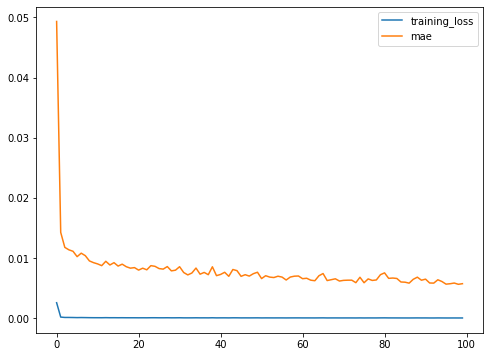

In [254]:
history = pd.DataFrame(model_adam.history.history)
plot_metrics(history, 100)

In [256]:
## generate forecast data

forecast_data = input_data[split_time-window_size:-1]
predictions = prediction(model_adam, forecast_data, batch_size, window_size)

results = predictions.squeeze()
print(results.shape)

16/16 [==============================] - 1s 21ms/step
(500,)


In [257]:
print('Mean Squared error :{}'.format(tf.metrics.mean_squared_error(true_values, results)))
print('Mean Absolute error :{}'.format(tf.metrics.mean_absolute_error(true_values, results)))

Mean Squared error :0.0008728860411792994
Mean Absolute error :0.024086104705929756


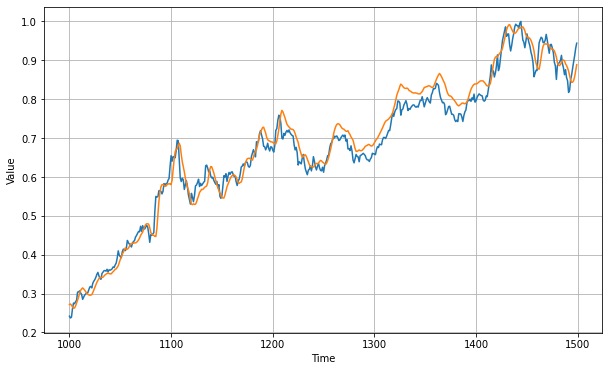

In [258]:
plot_series(valid_time, (true_values, results))

In [260]:
import sys
  
  
print("User Current Version:-", sys.version)

User Current Version:- 3.9.5 (tags/v3.9.5:0a7dcbd, May  3 2021, 17:27:52) [MSC v.1928 64 bit (AMD64)]


In [261]:
tf.__version__

'2.9.1'